In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("train.csv")

print("setup complete")

setup complete


In [2]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
categorical = [col for col in df.columns if(df[col].dtypes == "O")]
numerical = [col for col in df.columns if(df[col].dtypes != "O")]


print(df.shape)

(891, 12)


In [4]:
df[categorical].describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [5]:
df[numerical].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

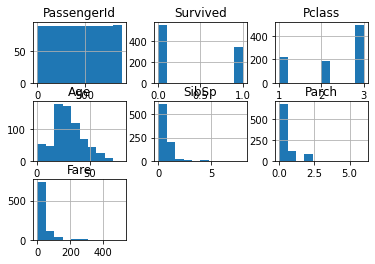

In [6]:
df[numerical].hist()

# Models

Here we will define all the modelling function to return the score for each dataset given. We will use this to pick the 
best preprocessing and modelling technqiue.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
print("lib loaded")

lib loaded


In [15]:

from sklearn.model_selection import cross_val_score
def utilCheckModel(processor, X, y, n_estimators, criterion, max_depth,min_samples_split,max_features, max_leaf_nodes):
    model = RandomForestClassifier(
            n_estimators = n_estimators, max_leaf_nodes = max_leaf_nodes,
            random_state = 23, criterion = criterion, max_depth = max_depth,
            min_samples_split = min_samples_split, max_features = max_features,
            n_jobs = -1
        )
    my_pipeline = Pipeline(steps = [
        ('preprocessor', processor),
        ('model', model)
    ])
    try:
        scores = cross_val_score(my_pipeline, X, y, cv = 5)
        return scores.mean()
    except ValueError:
        print("Obtained ValueError")
        return 0

def checkModel(processor, X, y):
    params = {
        'n_estimators' : [100, 200, 250, 350],
        'criterion' : ['gini', 'entropy'],
        'max_depth' : [5, 10, 15, 25, 30, 40, 45],
        'min_samples_split' : [2, 5, 8, 10],
        'max_features' : ['auto', 'sqrt', 'log2'],
        'max_leaf_nodes' : [x for x in range(2, 41, 3)]
    }

    res = [{}, 0];
    for a in params['n_estimators']:
        for b in params['criterion']:
            for c in params['max_depth']:
                for d in params['min_samples_split']:
                    for e in params['max_features']:
                        for f in params['max_leaf_nodes']:
                            values = {
                                'n_estimators' : a,
                                'criterion' : b,
                                'max_depth' : c,
                                'min_samples_split' : d,
                                'max_featuers': e,
                                'max_leaf_nodes' : f
                            }
                            score = utilCheckModel(processor, X, y, a, b, c, d, e, f)
                            if (score > res[1]):
                                print ("obtained new score ", score, values)
                                res = [values, score]
    return res
    
    


In [10]:
df.drop(["PassengerId", "Name", "Ticket"], axis = 1, inplace=True) # highly cardinal columns
X = df.drop("Survived", axis = 1)
y = df["Survived"]


In [11]:
categorical = [col for col in X.columns if(df[col].dtypes == "O")]
numerical = [col for col in X.columns if(df[col].dtypes != "O")]
X['Cabin'] = X['Cabin'].str[0]


In [12]:
print(categorical)
print(numerical)

['Sex', 'Cabin', 'Embarked']
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [13]:

numerical_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
    ])
categorical_transformer1 = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = "most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown = "ignore")),
])

categorical_transformer2 = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = "most_frequent")),
    ('woe', ce.HelmertEncoder()),
])

preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer, numerical),
    ('cat1', categorical_transformer1, ['Sex', 'Embarked']),
    ('cat2', categorical_transformer2, ['Cabin'])
])

In [ ]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.8, random_state=1)

In [16]:
import warnings
warnings.filterwarnings('ignore')
print(checkModel(preprocessor, X, y))

obtained new score  0.7722114117130123 {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'max_featuers': 'auto', 'max_leaf_nodes': 2}
obtained new score  0.7912748728893352 {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'max_featuers': 'auto', 'max_leaf_nodes': 5}
obtained new score  0.8069487163392128 {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'max_featuers': 'auto', 'max_leaf_nodes': 8}
obtained new score  0.8080785889146945 {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'max_featuers': 'auto', 'max_leaf_nodes': 11}
obtained new score  0.8080911430544221 {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'max_featuers': 'auto', 'max_leaf_nodes': 14}
obtained new score  0.8125792480070302 {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'max_featuers': 'auto', 'max_leaf_nodes':

KeyboardInterrupt: 

# TEST RESULT GENERATION

In [19]:
test_df = pd.read_csv("test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [20]:
psgId = test_df["PassengerId"]
test_df.drop(["PassengerId", "Name", "Ticket"], axis = 1, inplace=True)
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,34.5,0,0,7.8292,NaN,Q
1,3,female,47.0,1,0,7.0000,NaN,S
2,2,male,62.0,0,0,9.6875,NaN,Q
3,3,male,27.0,0,0,8.6625,NaN,S
4,3,female,22.0,1,1,12.2875,NaN,S


In [21]:
final_model = RandomForestClassifier(n_estimators = 100,max_leaf_nodes = 38, random_state = 23, criterion = "entropy",
    max_depth = 10, min_samples_split = 2, max_features = "auto", 
    n_jobs = -1)
final_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', final_model)
])

final_pipeline.fit(X, y)
y_pred = final_pipeline.predict(test_df)

In [22]:
res = pd.DataFrame({
    'PassengerId' : psgId,
    'Survived' : y_pred
})

In [23]:
res.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [27]:
res.to_csv("submission5.0.csv", index=False)

In [28]:
check = pd.read_csv("submission5.0.csv")
check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
